In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
np.set_printoptions(suppress=True)

In [2]:
from utils import *
from datasets import *
from classifiers import *
from metrics import *

In [3]:
from lda import LDA
from pca import PCA
from eigenface import *

# Utils Functions

In [4]:
def sign(x):
    return 1 if x>0 else -1

In [5]:
def cross_validation(model, X, y, k=5, dimension_reduction='None', n_components=2, random_seed=10):
    N = X.shape[0]
    indices = np.array([i for i in range(N)])
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    accuracys = []
    for i in range(k):
        # Split train data and test data
        low = int(i * (N/k))
        high = int((i+1) * (N/k))
        test_idx = np.take(indices, range(low, high))
        train_idx = np.delete(indices, range(low, high))
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        if dimension_reduction == 'PCA':
            pca = PCA(n_components=n_components)
            X_low_train = pca.fit(X_train).transform(X_train)
            X_low_test  = pca.fit(X_train).transform(X_test)
            X_train = X_low_train
            X_test = X_low_test
        elif dimension_reduction == 'LDA':
            lda = LDA(n_components=n_components)
            X_low_train = lda.fit(X_train, y_train).transform(X_train)
            X_low_test  = lda.fit(X_train, y_train).transform(X_test)
            X_train = X_low_train
            X_test = X_low_test
        
        # Train model with training data and evaluate on test data
        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_acc = accuracy(y_test, y_pred)
        accuracys.append(test_acc)
    return np.mean(accuracys), np.std(accuracys)

In [6]:
# change y from [0, 1, 2] to [[1,0,0], [0,1,0], [0,0,1]] 
def onehot(labels, num_classes=None):
    if num_classes is None:
        num_classes = max(len(set(labels)), max(labels)+1)
    M = len(labels)
    y_onehot = np.zeros((M, num_classes))
    for i, label in enumerate(labels):
        y_onehot[i, label] = 1.0
    return y_onehot
    
def one_versus_all(y, c):
    # y is MxC where M is # instance and C is # classes
    M, C = y.shape
    y_ova = np.zeros((M,2))
    y_ova[:, 1] = y[:, c]
    y_ova[:, 0] = 1 - y_ova[:, 1]
    return y_ova

In [18]:
def cross_validation_roc(model, X, y, k=5, 
                         dimension_reduction='None', n_components=2, random_seed=10, label_name=""):
    N = X.shape[0]
    indices = np.array([i for i in range(N)])
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    accuracys = []
    confusion_mats = []
    y_pred_probs = []
    y_tests = []
    for i in range(k):
        # Split train data and test data
        low = int(i * (N/k))
        high = int((i+1) * (N/k))
        test_idx = np.take(indices, range(low, high))
        train_idx = np.delete(indices, range(low, high))
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        if dimension_reduction == 'PCA':
            pca = PCA(n_components=n_components)
            X_low_train = pca.fit(X_train).transform(X_train)
            X_low_test  = pca.fit(X_train).transform(X_test)
            X_train = X_low_train
            X_test = X_low_test
        elif dimension_reduction == 'LDA':
            lda = LDA(n_components=n_components)
            X_low_train = lda.fit(X_train, y_train).transform(X_train)
            X_low_test  = lda.fit(X_train, y_train).transform(X_test)
            X_train = X_low_train
            X_test = X_low_test
        # Train model with training data and evaluate on test data
        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_acc = accuracy(y_test, y_pred)
        accuracys.append(test_acc)
        confusion_mat = confusion_matrix(y_test, y_pred)
        confusion_mats.append(confusion_mat)
        
        # ROC
        y_pred_prob = model.predict_prob(X_test)
        y_tests += list(y_test)
        y_pred_probs += list(y_pred_prob)
    # Roc
    y_test = np.array(y_tests)
    y_pred_prob = np.array(y_pred_probs)
    y_pred_prob = y_pred_prob[:, 1].reshape(-1)
    #FPR, TPR = ROC(y_test, y_pred_prob, label=str(model))
    FPR, TPR = ROC(y_test, y_pred_prob, label=label_name)
    confusion_mat = confusion_mats[0]
    for i in range(1, len(confusion_mats)):
        confusion_mat += confusion_mats[i]
    
    return np.mean(accuracys), np.std(accuracys), confusion_mat

# LDA

## Gender

In [19]:
img_male = cv2.imread("data/mP1.bmp", 0)
img_female = cv2.imread("data/fP1.bmp", 0)
imgs_male, _ = split_img(img_male, flip=True)
imgs_female, _ = split_img(img_female, flip=True)
male_data = imgs_male.reshape( (prod(imgs_male.shape[:1]), prod(imgs_male.shape[1:])) )
female_data = imgs_female.reshape( (prod(imgs_female.shape[:1]), prod(imgs_female.shape[1:])) ) 
male_label   = np.zeros(male_data.shape[0])
female_label = np.ones(female_data.shape[0])

X = np.concatenate((male_data, female_data), axis=0)
y = np.concatenate((male_label, female_label), axis=0)
print(X.shape)
print(y.shape)

(400, 1600)
(400,)


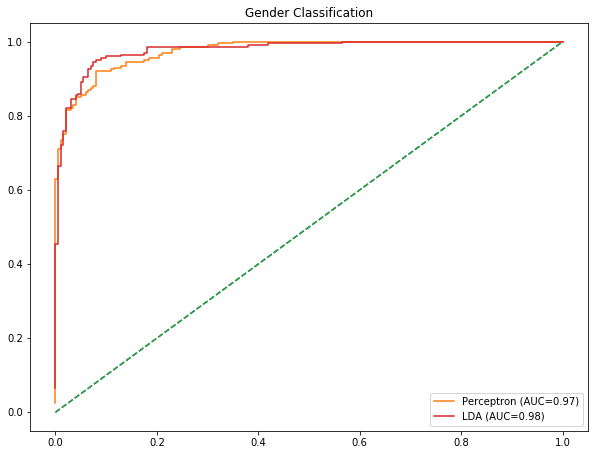

In [20]:
N, D = X.shape
plt.figure(figsize=(10,7.5))

# plt.subplot(1, 2, 1)
models = [PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10, label_name="Perceptron")
plt.title("Perceptron")

# plt.subplot(1,2,2)
models = [NaiveBayesClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10, 
                                              dimension_reduction='LDA', n_components=1, label_name="LDA")
plt.title('Gender Classification')
plt.show()

## separability measure

In [22]:
def separability_measure(X, Y):
    N, D = X.shape
    class_1 = []
    class_2 = []
    for (x, y) in zip(X, Y):
        if y == 0:
            class_1.append(x)
        else:
            class_2.append(x)
    c1 = np.array(class_1)
    c2 = np.array(class_2)
    u1 = np.mean(c1, axis=0).reshape(-1, 1)
    u2 = np.mean(c2, axis=0).reshape(-1, 1)
    
    # Within-class scatter matrix
    scatter_within = np.zeros((D,D))
    for (x, y) in zip(X, Y):
        x = x.reshape(-1, 1)
        if y == 0:
            scatter_within += np.dot((x-u1), (x-u1).T)/len(c1)
        else:
            scatter_within += np.dot((x-u1), (x-u1).T)/len(c2)
            
    # Between-class scatter matrix:
    u0 = np.mean(X, axis=0).reshape(-1, 1)
    scatter_between = np.zeros((D,D))
    scatter_between += np.dot( (u1-u0), (u1-u0).T)
    scatter_between += np.dot( (u2-u0), (u2-u0).T)
    
    # Mixture scatter matrix:
    scatter_mixture =  scatter_between + scatter_within
    
    return scatter_within, scatter_between, scatter_mixture

In [34]:
from numpy import trace 
from numpy.linalg import det, inv

# # dataset = 'Banknote'
# dataset = 'BreastCancer'
# X, y = read_dataset(dataset=dataset)

img_male = cv2.imread("data/mP1.bmp", 0)
img_female = cv2.imread("data/fP1.bmp", 0)
imgs_male, _ = split_img(img_male, flip=False)
imgs_female, _ = split_img(img_female, flip=False)
male_data = imgs_male.reshape( (prod(imgs_male.shape[:1]), prod(imgs_male.shape[1:])) )
female_data = imgs_female.reshape( (prod(imgs_female.shape[:1]), prod(imgs_female.shape[1:])) ) 
male_label   = np.zeros(male_data.shape[0])
female_label = np.ones(female_data.shape[0])
X = np.concatenate((male_data, female_data), axis=0)
y = np.concatenate((male_label, female_label), axis=0)
print(X.shape)
print(y.shape)

Sw, Sb, Sm = separability_measure(X, y)
J1 = trace(Sm) / trace(Sw)
J2 = det(Sm) / det(Sw)
J3 = trace(np.dot(inv(Sw), Sm))
print(J1, J2, J3)

(200, 1600)
(200,)


C:\Users\nilab\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


1.1348789200657414 nan -2282.7275390625


In [35]:
print(Sw)

[[14563.736   7767.8991  2984.5849 ... -2754.1836 -2229.7658 -1395.4652]
 [ 7767.8991  7507.0498  3908.3181 ... -3531.0105 -3396.3372 -2792.9078]
 [ 2984.5849  3908.3181  3937.75   ... -3681.0079 -4000.343  -3574.881 ]
 ...
 [-2754.1836 -3531.0105 -3681.0079 ... 26796.6752 25611.6738 23343.5732]
 [-2229.7658 -3396.3372 -4000.343  ... 25611.6738 26757.792  24928.586 ]
 [-1395.4652 -2792.9078 -3574.881  ... 23343.5732 24928.586  25179.036 ]]


In [24]:
lda = LDA(n_components=1)
X_low_lda = lda.fit(X, y).transform(X)

Sw, Sb, Sm = separability_measure(X_low_lda, y)
J1 = trace(Sm) / trace(Sw)
J2 = det(Sm) / det(Sw)
J3 = trace(np.dot(inv(Sw), Sm))
print(Sb/Sw)
print(J1, J2, J3)

[[0.4779]]
1.4779295634517193 1.4779295634517193 1.4779295634517196


PCA

## Banknote

In [25]:
dataset = 'Banknote'
X, y = read_dataset(dataset=dataset)
print(X.shape)

(1372, 4)


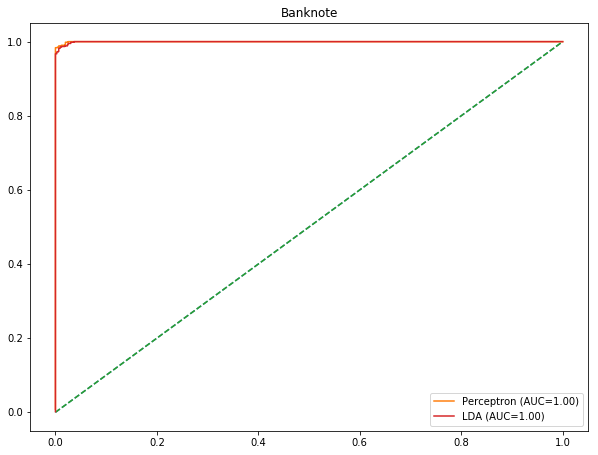

In [27]:
N, D = X.shape
plt.figure(figsize=(10,7.5))

# plt.subplot(1, 2, 1)
models = [PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10, label_name="Perceptron")
plt.title("Perceptron")

# plt.subplot(1,2,2)
models = [NaiveBayesClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10, 
                                              dimension_reduction='LDA', n_components=1, label_name="LDA")
plt.title('Banknote')
plt.show()

## BreastCancer

In [28]:
dataset = 'BreastCancer'
X, y = read_dataset(dataset=dataset)
print(X.shape)

(116, 9)


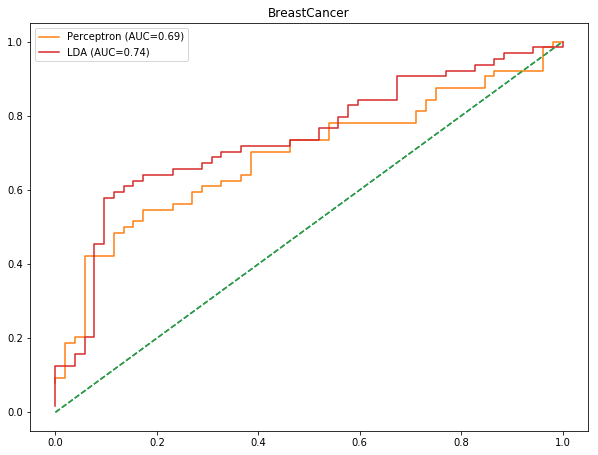

In [29]:
N, D = X.shape
plt.figure(figsize=(10,7.5))

# plt.subplot(1, 2, 1)
models = [PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10, label_name="Perceptron")
plt.title("Perceptron")

# plt.subplot(1,2,2)
models = [NaiveBayesClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10, 
                                              dimension_reduction='LDA', n_components=1, label_name="LDA")
plt.title("BreastCancer")
plt.show()

# PCA

## Breast Cancer

In [54]:
dataset = 'BreastCancer'
X, y = read_dataset(dataset=dataset)
print(X.shape)
print(y.shape)

(116, 9)
(116,)


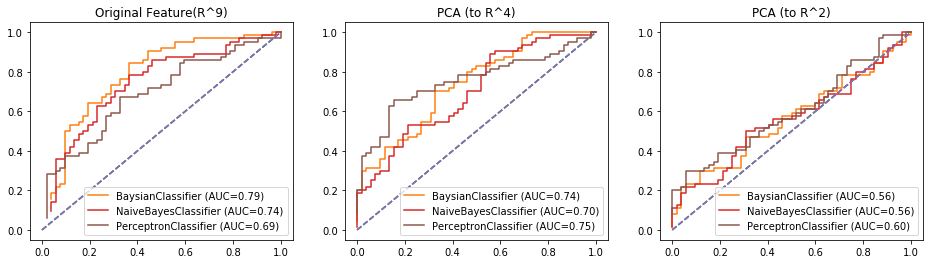

In [56]:
N, D = X.shape
plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=100)
plt.title("Original Feature(R^9)")

plt.subplot(1,3,2)
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, 
                                              dimension_reduction='PCA', n_components=4, random_seed=100)
plt.title("PCA (to R^4)")
    
plt.subplot(1,3,3)
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, 
                                              dimension_reduction='PCA', n_components=2, random_seed=100)
plt.title("PCA (to R^2)")
plt.show()

## Banknote

In [33]:
dataset = 'Banknote'
X, y = read_dataset(dataset=dataset)
print(X.shape)
print(y.shape)

(1372, 4)
(1372,)


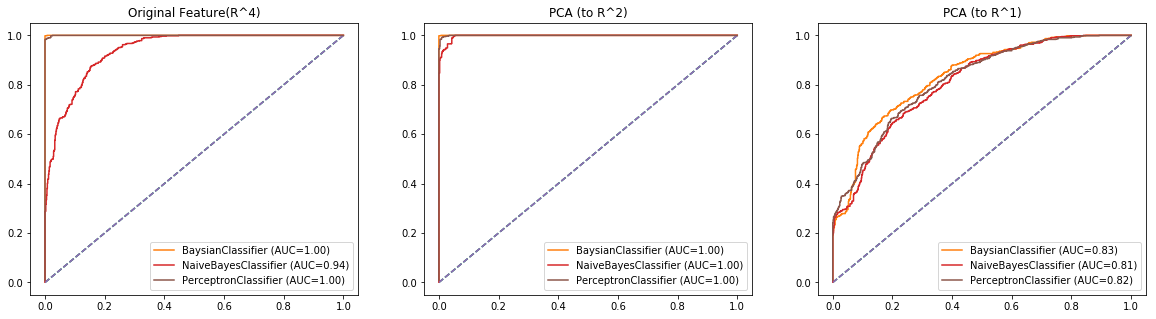

In [34]:
N, D = X.shape
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, random_seed=10)
plt.title("Original Feature(R^4)")

plt.subplot(1,3,2)
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, 
                                              dimension_reduction='PCA', n_components=4, random_seed=10)
plt.title("PCA (to R^2)")
    
plt.subplot(1,3,3)
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    _, _, confusion_mat = cross_validation_roc(model, X, y, k=5, 
                                              dimension_reduction='PCA', n_components=2, random_seed=10)
plt.title("PCA (to R^1)")

plt.show()

## Iris

In [35]:
dataset = 'iris'
X, y = read_dataset(dataset=dataset)
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [36]:
print("Original (R^4)")
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    acc_mean, acc_std = cross_validation(model, X, y, k=5, random_seed=100)
    print(model, acc_mean, acc_std)
    
print("PCA (R^2)")
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    acc_mean, acc_std = cross_validation(model, X, y, k=5, random_seed=100,
                                        dimension_reduction='PCA', n_components=2)
    print(model, acc_mean, acc_std)
    
    
print("PCA (R^1)")
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]
for model in models:
    acc_mean, acc_std = cross_validation(model, X, y, k=5, random_seed=100,
                                        dimension_reduction='PCA', n_components=1)
    print(model, acc_mean, acc_std)

Original (R^4)
BaysianClassifier 0.9666666666666668 0.05163977794943221
NaiveBayesClassifier 0.9600000000000002 0.03265986323710903
PerceptronClassifier 0.6666666666666666 0.09189365834726815
PCA (R^2)
BaysianClassifier 0.9733333333333334 0.024944382578492935
NaiveBayesClassifier 0.9 0.04216370213557838
PerceptronClassifier 0.6599999999999999 0.09043106644167026
PCA (R^1)
BaysianClassifier 0.9333333333333333 0.036514837167011066
NaiveBayesClassifier 0.9333333333333333 0.036514837167011066
PerceptronClassifier 0.6599999999999999 0.09043106644167026


# Eigenface & Classification

## Face Recognition

In [60]:
# Read Data
img = cv2.imread("data/facesP1.bmp", 0)
imgs, y = split_img(img, flip=True)
X = imgs.reshape( (prod(imgs.shape[:1]), prod(imgs.shape[1:])) )
print(X.shape)
print(y.shape)

(160, 1600)
(160,)


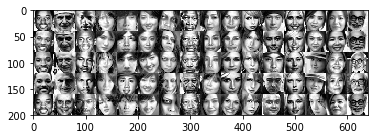

In [61]:
plt.imshow(img, cmap='gray')

In [70]:
print(16*8)

128


In [65]:
X_train, y_train = X[:-32], y[:-32]
X_test, y_test = X[-32:-16], y[-32:-16]

In [66]:
eigenface = EigenFace()
eigenface.fit(X_train, y_train, k=128)
# eigenface.show_eigen_face(k=25)

In [67]:
from tqdm import tqdm_notebook as tqdm
acc = []
ks = []
for k in tqdm(range(1, 50+1)):
    n_eigenvec = 25
    correct = 0
    total = len(X_test)
    for img_vec, label in zip(X_test, y_test):
        img = vec2img(img_vec)
        img_predict, y_pred = eigenface.predict(img, n_eigenvec=k)
        if y_pred == label:
            correct += 1
    acc.append(correct / total)
    ks.append(k)

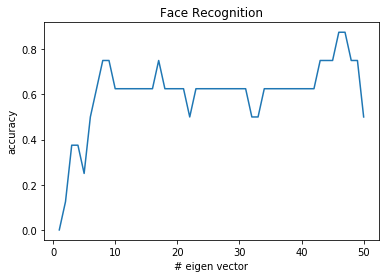

In [68]:
plt.plot(ks, acc)
plt.title("Face Recognition")
plt.xlabel("# eigen vector")
plt.ylabel("accuracy")
plt.show()

## gender classification

In [73]:
img_male = cv2.imread("data/mP1.bmp", 0)
img_female = cv2.imread("data/fP1.bmp", 0)
imgs_male, _ = split_img(img_male, flip=True)
imgs_female, _ = split_img(img_female, flip=True)

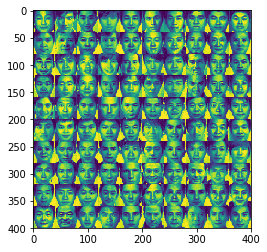

In [78]:
plt.imshow(img_male)

In [74]:
# Reshape Image to Vector
male_data = imgs_male.reshape( (prod(imgs_male.shape[:1]), prod(imgs_male.shape[1:])) )
female_data = imgs_female.reshape( (prod(imgs_female.shape[:1]), prod(imgs_female.shape[1:])) ) 
print(male_data.shape)
print(female_data.shape)

(200, 1600)
(200, 1600)


In [75]:
# Create Training Data
male_label   = np.zeros(male_data.shape[0])
female_label = np.ones(female_data.shape[0])

X_train = np.concatenate((male_data[:-20], female_data[:-20]), axis=0)
y_train = np.concatenate((male_label[:-20], female_label[:-20]), axis=0)
X_test = np.concatenate((male_data[-20:-10], female_data[-20:-10]), axis=0)
y_test = np.concatenate((male_label[-20:-10], female_label[-20:-10]), axis=0)
print(X_train.shape)
print(y_train.shape)

(360, 1600)
(360,)


In [76]:
eigenface = EigenFace()
eigenface.fit(X_train, y_train, k=360)

In [77]:
from tqdm import tqdm_notebook as tqdm
acc = []
ks = []
for k in tqdm(range(1, 50+1)):
    n_eigenvec = 25
    correct = 0
    total = len(X_test)
    for img_vec, label in zip(X_test, y_test):
        img = vec2img(img_vec)
        img_predict, y_pred = eigenface.predict(img, n_eigenvec=k)
        if y_pred == label:
            correct += 1
    acc.append(correct / total)
    ks.append(k)

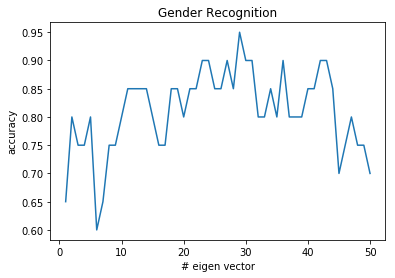

In [47]:
plt.plot(ks, acc)
plt.title("Gender Recognition")
plt.xlabel("# eigen vector")
plt.ylabel("accuracy")
plt.show()

# Old codes

(1372, 4)
BaysianClassifier Banknote
[[610.   0.]
 [ 23. 739.]]
NaiveBayesClassifier Banknote
[[483. 127.]
 [ 92. 670.]]
PerceptronClassifier Banknote
[[603.   7.]
 [  5. 757.]]


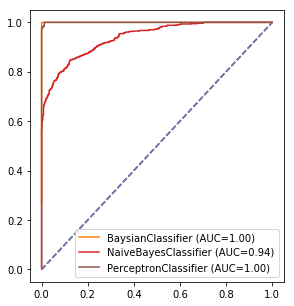

(116, 9)
BaysianClassifier BreastCancer
[[45.  7.]
 [33. 31.]]
NaiveBayesClassifier BreastCancer
[[46.  6.]
 [39. 25.]]
PerceptronClassifier BreastCancer
[[35. 17.]
 [23. 41.]]


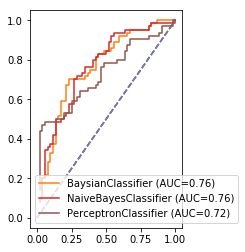

In [11]:
datasets = ['Banknote', 'BreastCancer']
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]

n_figures = len(datasets)
plt.figure(figsize=(5*n_figures, 5))

for i, dataset in enumerate(datasets):
    plt.subplot(1, n_figures, i+1)
    X, y = read_dataset(dataset=dataset)
    print(X.shape)
    for model in models:
        _, _, confusion_mat = cross_validation_roc(model, X, y, k=10)
        print(model, dataset)
        print(confusion_mat)
    plt.show()
plt.show()

In [6]:
## Two binary-classes datasets
## Two multi-classes datasets

''' Training Process
(X_train, y_train), (X_test, y_test) = split_data(X, y)
model = Classifier()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_train)
confusion_matrix = get_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_matrix)
discriminant_function = model.get_discriminant_function()
print(dicriminant_function)
'''
''

''

In [7]:
# Train & Test model
def train_and_test_model(model, X, y, dataset_name='', verbose=False):
    if verbose:
        print('='*40 + "\n(Dataset: {}) \n(Classifier: {})\n".format(dataset_name, str(model)) + '-'*40)
    X, y = read_dataset_BreastCancer()
    (X_train, y_train), (X_test, y_test) = split_data(X, y, split_ratio=0.9)
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    train_acc = accuracy(y_train, y_pred)
    if verbose:
        print('Train Accuracy: %.2f %%' % (train_acc * 100))

    y_pred = model.predict(X_test)
    test_acc = accuracy(y_test, y_pred)
    if verbose:
        print('Test Accuracy:  %.2f %%' % (test_acc * 100))
        print('='*40)
    return train_acc, test_acc

In [8]:
X, y = read_dataset_BreastCancer()
X, y = read_dataset_Banknote()

model = BayesianClassifier()
avg_acc, std_acc = cross_validation(model, X, y, k=5)
print(avg_acc, std_acc)

model = NaiveBayesClassifier()
avg_acc, std_acc = cross_validation(model, X, y, k=5)
print(avg_acc, std_acc)

model = PerceptronClassifier()
avg_acc, std_acc = cross_validation(model, X, y, k=5)
print(avg_acc, std_acc)

0.8170564034505642 0.012915426049084982
0.5779827471798276 0.02966133168153952
0.8170643662906437 0.022935680245985888


BaysianClassifier BreastCancer
[[ 9.  2.]
 [11.  7.]]
[[0.81818182 0.18181818]
 [0.61111111 0.38888889]]
NaiveBayesClassifier BreastCancer
[[ 8.  3.]
 [10.  8.]]
[[0.72727273 0.27272727]
 [0.55555556 0.44444444]]
PerceptronClassifier BreastCancer
[[ 5.  6.]
 [ 4. 14.]]
[[0.45454545 0.54545455]
 [0.22222222 0.77777778]]
BaysianClassifier Banknote
[[152.  31.]
 [ 25. 135.]]
[[0.83060109 0.16939891]
 [0.15625    0.84375   ]]
NaiveBayesClassifier Banknote
[[136.  47.]
 [105.  55.]]
[[0.7431694 0.2568306]
 [0.65625   0.34375  ]]
PerceptronClassifier Banknote
[[145.  38.]
 [ 23. 137.]]
[[0.79234973 0.20765027]
 [0.14375    0.85625   ]]


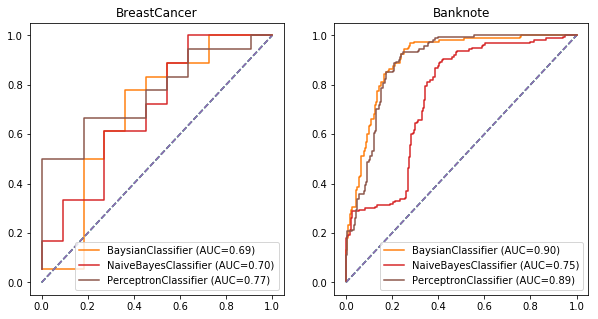

In [25]:
datasets = ['BreastCancer', 'Banknote']
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]

n_figures = len(datasets)
plt.figure(figsize=(5*n_figures, 5))

for i, dataset in enumerate(datasets):
    plt.subplot(1, n_figures, i+1)
    X, y = read_dataset(dataset=dataset)
    (X_train, y_train), (X_test, y_test) = split_data(X, y, split_ratio=0.75)
    for model in models:
        model = model.fit(X_train, y_train)
        y_pred_prob = model.predict_prob(X_test)
        y_pred_prob = y_pred_prob[:, 1].reshape(-1)
        FPR, TPR = ROC(y_test, y_pred_prob, label=str(model))
        plt.title(dataset)
        
        print(model, dataset)
        preds = model.predict(X_test)
        confusion_mat = confusion_matrix(y_test, preds)
        print(confusion_mat)

        preds = model.predict(X_test)
        confusion_mat = confusion_matrix(y_test, preds, normalzied=True)
        print(confusion_mat)
plt.show()

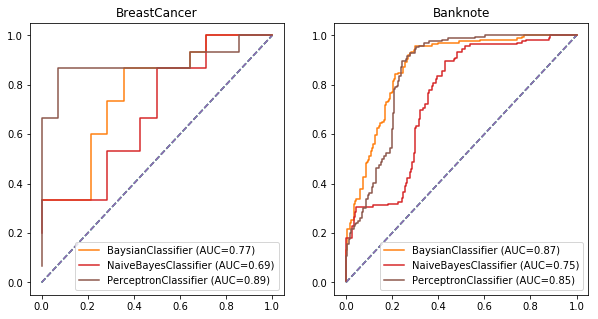

In [17]:
datasets = ['BreastCancer', 'Banknote']
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]

n_figures = len(datasets)
plt.figure(figsize=(5*n_figures, 5))

for i, dataset in enumerate(datasets):
    plt.subplot(1, n_figures, i+1)
    X, y = read_dataset(dataset=dataset)
    (X_train, y_train), (X_test, y_test) = split_data(X, y, split_ratio=0.75)
    for model in models:
        model = model.fit(X_train, y_train)
        y_pred_prob = model.predict_prob(X_test)
        y_pred_prob = y_pred_prob[:, 1].reshape(-1)
        FPR, TPR = ROC(y_test, y_pred_prob, label=str(model))
        plt.title(dataset)
plt.show()

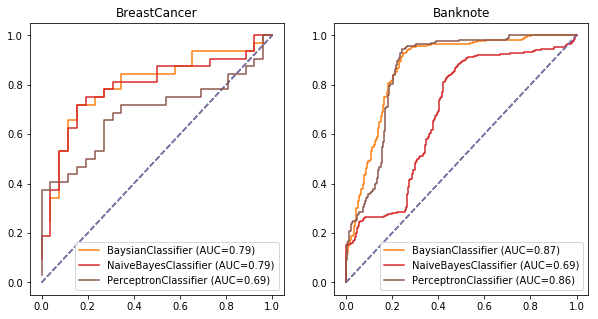

In [13]:
datasets = ['BreastCancer', 'Banknote']
models = [BayesianClassifier(), NaiveBayesClassifier(), PerceptronClassifier()]

n_figures = len(datasets)
plt.figure(figsize=(5*n_figures, 5))

for i, dataset in enumerate(datasets):
    plt.subplot(1, n_figures, i+1)
    X, y = read_dataset(dataset=dataset)
    (X_train, y_train), (X_test, y_test) = split_data(X, y, split_ratio=0.5)
    for model in models:
        model = model.fit(X_train, y_train)
        y_pred_prob = model.predict_prob(X_test)
        y_pred_prob = y_pred_prob[:, 1].reshape(-1)
        FPR, TPR = ROC(y_test, y_pred_prob, label=str(model))
        plt.title(dataset)
plt.show()

In [35]:
def subset(X, y, num_instance_each_class=1):
    num_classes = len(set(y))
    indices_class = [[] for c in range(num_classes)]
    for i in range(len(y)):
        indices_class[y[i]] += [i]
    for c in range(num_classes):
        np.random.shuffle(indices_class[c])
    X_subset = []
    y_subset = []
    
    for c in range(num_classes):
        for idx in indices_class[c][:num_instance_each_class]:
            X_subset.append(X[idx])
            y_subset.append(y[idx])
    return np.array(X_subset), np.array(y_subset)

In [58]:
X, y = read_dataset(dataset='Wine')
print(X.shape)
print(y.shape)

(178, 13)
(178,)


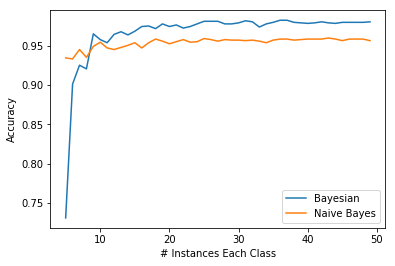

In [76]:
X, y = read_dataset(dataset='iris')

acc_bayes = []
acc_naive = []
n_instance = [i for i in range(5, 50)]

for n in n_instance:
    acc_b = 0
    acc_n = 0
    for i in range(10):
        X_subset, y_subset = subset(X, y, num_instance_each_class=n)
        model = BayesianClassifier()
        model = model.fit(X_subset, y_subset)
        y_pred = model.predict(X)
        acc_b += accuracy(y, y_pred)
        
        model = NaiveBayesClassifier()
        model = model.fit(X_subset, y_subset)
        y_pred = model.predict(X)
        acc_n += accuracy(y, y_pred)
        
    acc_bayes.append(acc_b/10)
    acc_naive.append(acc_n/10)
    
    
plt.plot(n_instance, acc_bayes, label='Bayesian')
plt.plot(n_instance, acc_naive, label='Naive Bayes')
plt.legend(loc='best')
plt.xlabel("# Instances Each Class")
plt.ylabel("Accuracy")
plt.show()

In [8]:
datasets = ['Iris', 'Wine']
models = [BayesianClassifier(), NaiveBayesClassifier()]

for i, dataset in enumerate(datasets):
    X, y = read_dataset(dataset=dataset)
    for model in models:
        avg_acc, std_acc = cross_validation(model, X, y, k=5)
        print('[%s]'%dataset, '(%s)'%str(model), avg_acc, std_acc)

[Iris] (BaysianClassifier) 0.9666666666666668 0.036514837167011066
[Iris] (NaiveBayesClassifier) 0.9533333333333334 0.04988876515698587
[Wine] (BaysianClassifier) 0.9888888888888889 0.013608276348795441
[Wine] (NaiveBayesClassifier) 0.9661904761904762 0.021091409830949964


BaysianClassifier Iris
[[13.  0.  0.]
 [ 2. 10.  0.]
 [ 0.  0. 13.]]
0.9473684210526316
NaiveBayesClassifier Iris
[[12.  1.  0.]
 [ 2. 10.  0.]
 [ 0.  0. 13.]]
0.9210526315789473
BaysianClassifier Wine
[[19.  0.  0.]
 [ 0. 14.  0.]
 [ 0.  0. 12.]]
1.0
NaiveBayesClassifier Wine
[[18.  0.  1.]
 [ 0. 14.  0.]
 [ 0.  0. 12.]]
0.9777777777777777


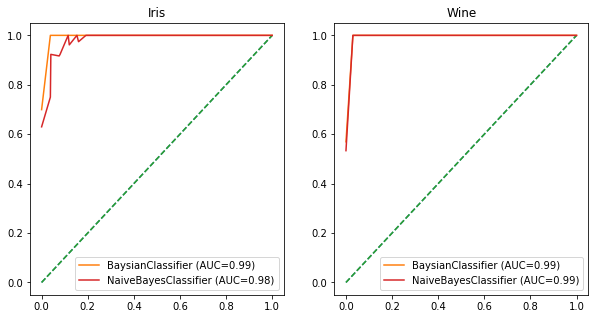

In [40]:
datasets = ['Iris', 'Wine']
models = [BayesianClassifier(), NaiveBayesClassifier()]

n_figures = len(datasets)
plt.figure(figsize=(5*n_figures, 5))

for i, dataset in enumerate(datasets):
    plt.subplot(1, n_figures, i+1)
    X, y = read_dataset(dataset=dataset)
    (X_train, y_train), (X_test, y_test) = split_data(X, y, split_ratio=0.75)
    for model in models:
        model = model.fit(X_train, y_train)
        y_pred_prob = model.predict_prob(X_test)
        FPR, TPR = multiclass_ROC(onehot(y_test), y_pred_prob, label=str(model))
        plt.title(dataset)
        
        print(model, dataset)
        preds = model.predict(X_test)
        confusion_mat = confusion_matrix(y_test, preds)
        print(confusion_mat)
        
        test_acc = accuracy(y_test, preds)
        print(test_acc)
plt.show()

In [43]:
def cross_validation(model, X, y, k=5):
    N = X.shape[0]
    indices = np.array([i for i in range(N)])
    np.random.shuffle(indices)
    accuracys = []
    confusion_mats = []
    for i in range(k):
        # Split train data and test data
        low = int(i * (N/k))
        high = int((i+1) * (N/k))
        test_idx = np.take(indices, range(low, high))
        train_idx = np.delete(indices, range(low, high))
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model with training data and evaluate on test data
        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_acc = accuracy(y_test, y_pred)
        accuracys.append(test_acc)
        confusion_mat = confusion_matrix(y_test, y_pred)
        confusion_mats.append(confusion_mat)
    
    confusion_mat = confusion_mats[0]
    for i in range(1, len(confusion_mats)):
        confusion_mat += confusion_mats[i]
    
    return np.mean(accuracys), np.std(accuracys), confusion_mat

In [47]:
X, y = read_dataset(dataset='Iris')
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [46]:
datasets = ['Iris', 'Wine']
models = [BayesianClassifier(), NaiveBayesClassifier()]

n_figures = len(datasets)
plt.figure(figsize=(5*n_figures, 5))

for i, dataset in enumerate(datasets):
    X, y = read_dataset(dataset=dataset)
    for model in models:
        acc_mean, acc_std, confusion_mat = cross_validation(model, X, y, k=5)
        print(model, dataset)
        print(acc_mean)
        print(acc_std)
        print(confusion_mat)
        print('\n\n')
plt.show()

BaysianClassifier Iris
0.9666666666666668
0.036514837167011066
[[49.  1.  0.]
 [ 4. 46.  0.]
 [ 0.  0. 50.]]



NaiveBayesClassifier Iris
0.9533333333333334
0.03399346342395189
[[46.  4.  0.]
 [ 3. 47.  0.]
 [ 0.  0. 50.]]



BaysianClassifier Wine
0.9831746031746033
0.02230370548603213
[[70.  1.  0.]
 [ 1. 58.  0.]
 [ 1.  0. 47.]]



NaiveBayesClassifier Wine
0.9777777777777779
0.03239417719358502
[[69.  0.  2.]
 [ 2. 57.  0.]
 [ 0.  0. 48.]]





<Figure size 720x360 with 0 Axes>

In [116]:
# def ROC(y, y_pred_prob, label='ROC'):
#     thresholds = sorted(list(y_pred_prob))
#     FPR, TPR = [], []
#     for threshold in thresholds:
#         y_pred = y_pred_prob.copy()
#         y_pred[y_pred<threshold] = 0
#         y_pred[y_pred>=threshold] = 1
#         confusion_mat = confusion_matrix(y, y_pred)
#         TN, FP, FN, TP = tuple(confusion_mat.reshape(4))
#         FPR.append( FP/(FP+TN) )
#         TPR.append( TP/(TP+FN) )
#     plt.plot([0,1], [0,1], linestyle='dashed')
#     plt.plot(FPR, TPR, label='%s (AUC=%.2f)'%(label, AUC(FPR, TPR)))
#     plt.legend(loc='best')
#     return FPR, TPR